![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 07 - PyTorch 2 </center>
### <center> Hooks </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/07_PyTorch2/MainPyTorchHooks.ipynb)

A great ooks tutorial:  
https://www.youtube.com/watch?v=syLFCVYua6Q&t=1064s

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib
import torch

import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchinfo

#-- Fix seed (for presentation sake)
torch.manual_seed(0)
np.random.seed   (0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/07_PyTorch2/DeepLearningFramework ./DeepLearningFramework

### Download MNIST dataset:

In [5]:
import torchvision
import torchvision.transforms as transforms

DATA_PATH = r'../../data'
oTrainSet = torchvision.datasets.MNIST(root=DATA_PATH, train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape, oTrainSet[0][0].shape

(torch.Size([60000, 28, 28]), torch.Size([1, 28, 28]))

#### Compute mean and variance:

In [6]:
mean = oTrainSet.data.float().mean() / 255
std  = oTrainSet.data.float().std () / 255
print('µ =', mean)
print('σ =', std)

µ = tensor(0.1307)
σ = tensor(0.3081)


#### Set datasets with normalization:

In [7]:
oTransform = transforms.Compose([
    transforms.ToTensor (),
    transforms.Normalize(mean, std)
])

oTrainSet.transform = oTransform
oTestSet .transform = oTransform

lClasses  = oTrainSet.classes
lClasses

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

#### Create data loaders:

In [8]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

mX, vY    = next(iter(oTrainDL))
mX.shape

torch.Size([128, 1, 28, 28])

#### Define the model (2D CNN):

In [9]:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv2d(1,  8,  5, stride=1), nn.ReLU(),
        nn.Conv2d(8,  16, 5, stride=1), nn.ReLU(),
        nn.Conv2d(16, 32, 5, stride=1), nn.ReLU(),
        nn.Conv2d(32, 32, 5, stride=1), nn.ReLU(),
        nn.Conv2d(32, 32, 5, stride=1), nn.ReLU(),
        nn.Conv2d(32, 32, 5, stride=1), nn.ReLU(),
                        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten          (),
        nn.Linear           (32, 10),
    )
    
    return oModel
#------------------------------------------------------#
#------------------------------------------------------#
torchinfo.summary(GetModel(), mX.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [128, 1, 28, 28]          --
├─Conv2d: 1-2                            [128, 8, 24, 24]          208
├─ReLU: 1-3                              [128, 8, 24, 24]          --
├─Conv2d: 1-4                            [128, 16, 20, 20]         3,216
├─ReLU: 1-5                              [128, 16, 20, 20]         --
├─Conv2d: 1-6                            [128, 32, 16, 16]         12,832
├─ReLU: 1-7                              [128, 32, 16, 16]         --
├─Conv2d: 1-8                            [128, 32, 12, 12]         25,632
├─ReLU: 1-9                              [128, 32, 12, 12]         --
├─Conv2d: 1-10                           [128, 32, 8, 8]           25,632
├─ReLU: 1-11                             [128, 32, 8, 8]           --
├─Conv2d: 1-12                           [128, 32, 4, 4]           25

#### Device & loss:

In [10]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
Loss   = nn.CrossEntropyLoss()

#### Train the model:

In [11]:
from DeepLearningFramework.Training import TrainClassficationModel

nEpochs = 5
lr      = 2e-2
oModel  = GetModel().to(DEVICE)
oOptim  = optim.SGD(oModel.parameters(), lr=lr)

TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim);

Epoch 000: | Train loss: 2.00324 | Val loss: 0.72790 | Train Accuracy: 0.2439 | Val Accuracy: 0.7545 | epoch time:  5.338 | <-- Checkpoint!
Epoch 001: | Train loss: 0.36756 | Val loss: 0.21098 | Train Accuracy: 0.8844 | Val Accuracy: 0.9365 | epoch time:  3.688 | <-- Checkpoint!
Epoch 002: | Train loss: 0.18448 | Val loss: 0.14557 | Train Accuracy: 0.9427 | Val Accuracy: 0.9570 | epoch time:  3.696 | <-- Checkpoint!
Epoch 003: | Train loss: 0.13360 | Val loss: 0.11016 | Train Accuracy: 0.9587 | Val Accuracy: 0.9674 | epoch time:  3.728 | <-- Checkpoint!
Epoch 004: | Train loss: 0.10549 | Val loss: 0.08544 | Train Accuracy: 0.9675 | Val Accuracy: 0.9736 | epoch time:  3.727 | <-- Checkpoint!


#### Change initialization
The default initialization of conv layers is `kaiming_uniform_`.<br>
Let us try `kaiming_normal_`:

In [12]:
def WeightInit(oModule):
    if isinstance(oModule, nn.Conv2d):
        nn.init.kaiming_normal_(oModule.weight.data)

oModel = GetModel().to(DEVICE)
oModel.apply(WeightInit)  #-- initialize model

oOptim = optim.SGD(oModel.parameters(), lr=lr)
TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim);

Epoch 000: | Train loss: 0.50987 | Val loss: 0.11422 | Train Accuracy: 0.8337 | Val Accuracy: 0.9641 | epoch time:  3.777 | <-- Checkpoint!
Epoch 001: | Train loss: 0.10567 | Val loss: 0.08791 | Train Accuracy: 0.9674 | Val Accuracy: 0.9707 | epoch time:  3.744 | <-- Checkpoint!
Epoch 002: | Train loss: 0.07676 | Val loss: 0.06972 | Train Accuracy: 0.9761 | Val Accuracy: 0.9776 | epoch time:  3.773 | <-- Checkpoint!
Epoch 003: | Train loss: 0.06345 | Val loss: 0.05341 | Train Accuracy: 0.9803 | Val Accuracy: 0.9830 | epoch time:  3.763 | <-- Checkpoint!
Epoch 004: | Train loss: 0.05384 | Val loss: 0.04953 | Train Accuracy: 0.9834 | Val Accuracy: 0.9841 | epoch time:  3.713 | <-- Checkpoint!


###  Activation analysis using Hooks:

In [13]:
oModel

Sequential(
  (0): Identity()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (8): ReLU()
  (9): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (10): ReLU()
  (11): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (12): ReLU()
  (13): AdaptiveAvgPool2d(output_size=1)
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Linear(in_features=32, out_features=10, bias=True)
)

#### Write a `ForwardHook` function and hook it to the 6th layer (ReLU)

In [14]:
nEpochs = 1
nIter   = nEpochs * len(oTrainDL)
lRange  = [-1, 7]

class Stats:
    def __init__(self):
        self.nIter = nEpochs * len(oTestDL)
        self.vMean = np.full(nIter,        np.nan)
        self.vStd  = np.full(nIter,        np.nan)
        self.mHist = np.full((101, nIter), np.nan)
        self.iter  = 0

def ForwardHook(oLayer, mX, mZ):
    if oLayer.training == False: #-- skip validation
        return
    tt                         = oStats.iter
    oStats.vMean[tt]           = mZ.data.mean().cpu()
    oStats.vStd [tt]           = mZ.data.std ().cpu()
    oStats.mHist[:,tt], vEdges = np.histogram(mZ.data.view(-1).cpu(), bins=101, range=lRange)
    oStats.vEdges              = vEdges
    oStats.iter               += 1   

#### Run with default initialization:

In [15]:
oStats = Stats()
oModel = GetModel().to(DEVICE)
oLayer = oModel[6] #-- The activation after the 3rd conv layer
h      = oLayer.register_forward_hook(ForwardHook)

oOptim = optim.SGD(oModel.parameters(), lr=lr)
TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim)

h.remove() #-- remove hook
oStats1 = oStats

Epoch 000: | Train loss: 1.59058 | Val loss: 0.52603 | Train Accuracy: 0.4229 | Val Accuracy: 0.8231 | epoch time:  7.545 | <-- Checkpoint!


#### Run with `kaiming_normal_` initialization:

In [16]:
oStats = Stats()
oModel = GetModel().to(DEVICE)
oModel.apply(WeightInit)  #-- initialize model

oLayer = oModel[6] #-- The activation after the 3rd conv layer
h      = oLayer.register_forward_hook(ForwardHook)

oOptim = optim.SGD(oModel.parameters(), lr=lr)
TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim)

h.remove() #-- remove hook
oStats2 = oStats

Epoch 000: | Train loss: 0.49207 | Val loss: 0.13466 | Train Accuracy: 0.8428 | Val Accuracy: 0.9590 | epoch time:  8.104 | <-- Checkpoint!


In [17]:
def PlotStatistics(oStats, c, title):
    
    vMean = oStats.vMean
    vStd  = oStats.vStd
    mHist = oStats.mHist
    
    _, vAx = plt.subplots(1, 3, figsize=(22, 5))

    vAx[0].plot      (oStats.vMean, c=c)
    vAx[1].plot      (oStats.vStd,  c=c)
    vAx[2].imshow    (np.log(oStats.mHist + .1), origin='lower', extent=[0, oStats.iter, lRange[0], lRange[1]], aspect='auto')
    vAx[0].set_title ('Activation - mean')
    vAx[1].set_title ('Activation - std')
    vAx[2].set_title ('Activation - hist')
    vAx[0].set_xlabel('iteration')
    vAx[1].set_xlabel('iteration')
    vAx[2].set_xlabel('iteration')
    vAx[0].grid      ()
    vAx[1].grid      ()
    
    plt.tight_layout ()
    plt.suptitle     (title, y=1.05)

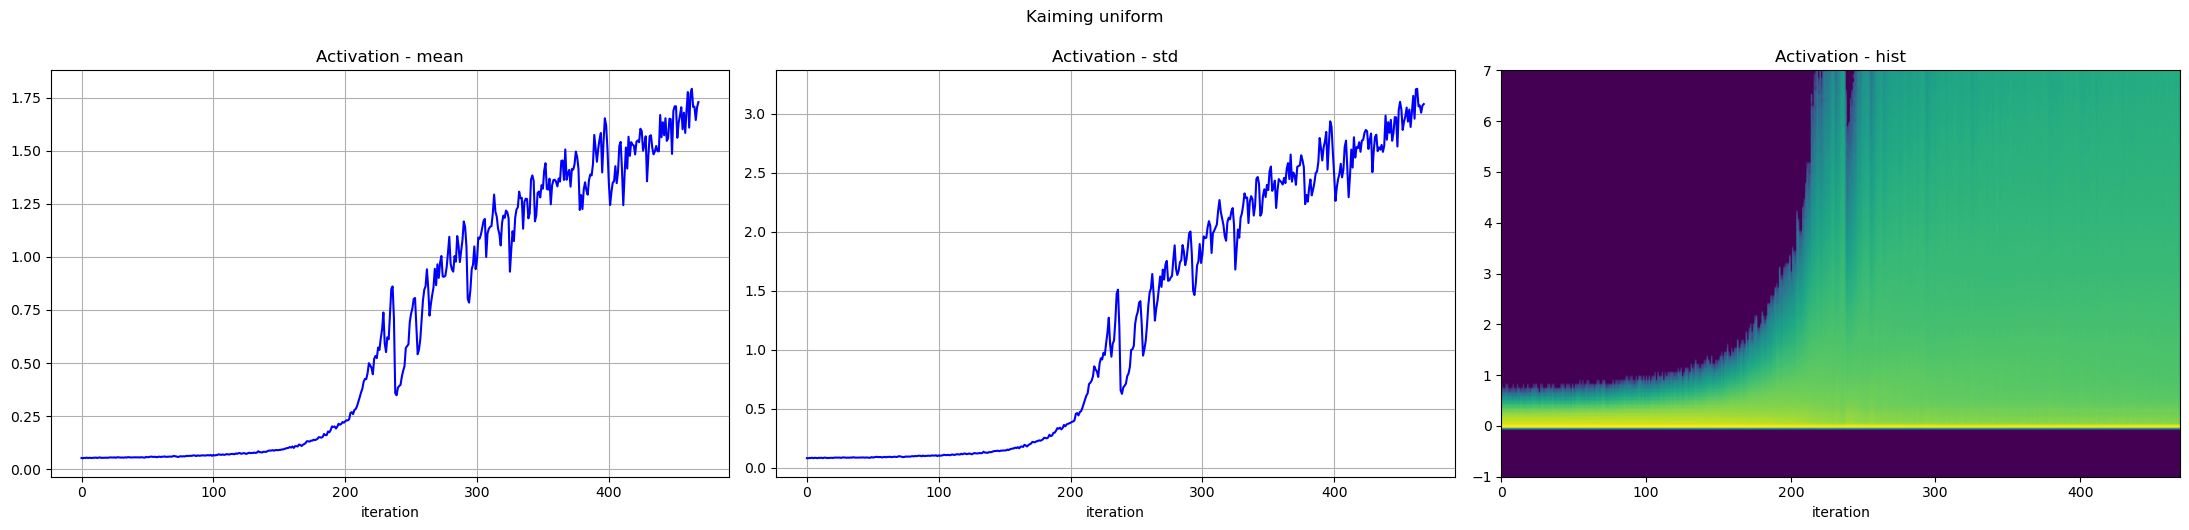

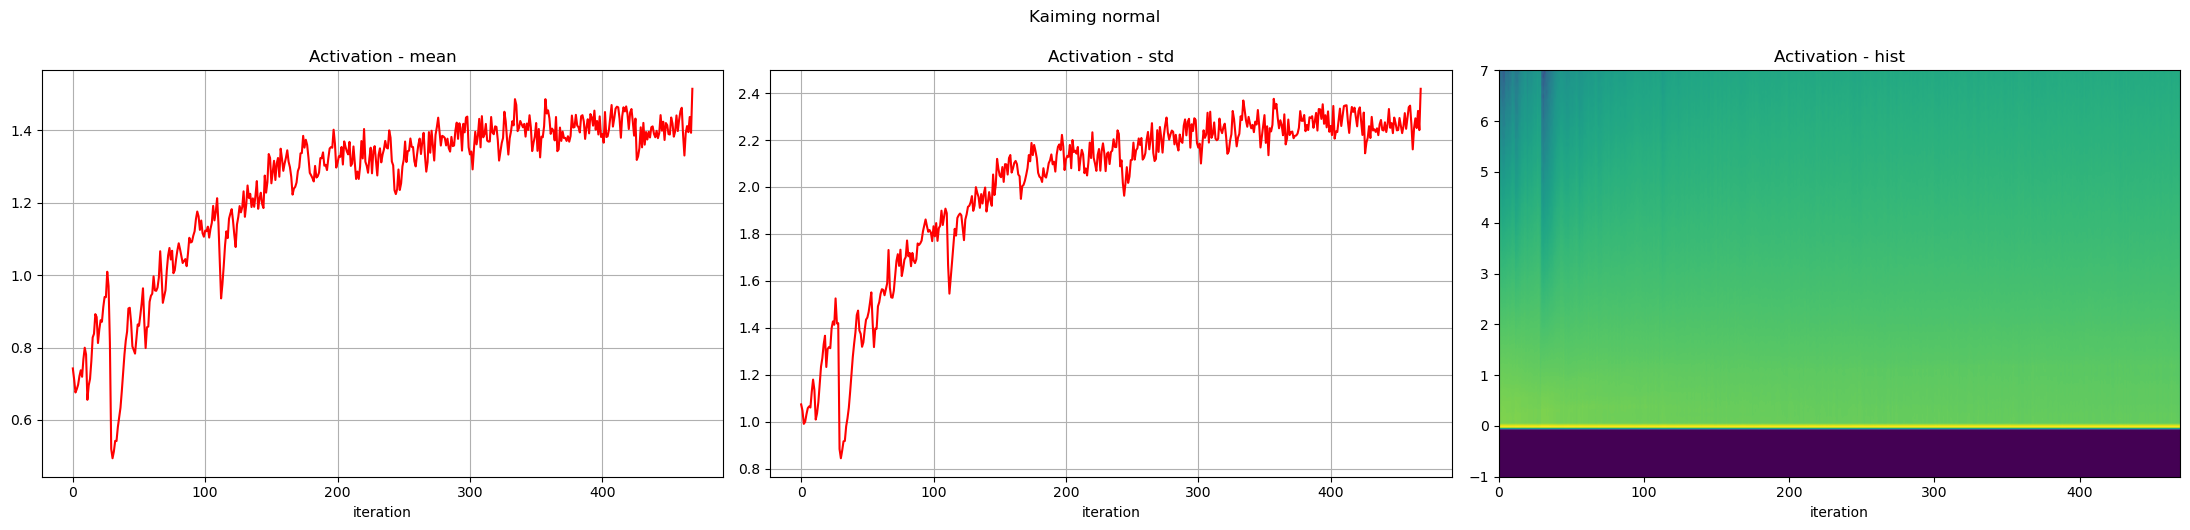

In [18]:
PlotStatistics(oStats1, 'b', 'Kaiming uniform')
PlotStatistics(oStats2, 'r', 'Kaiming normal')
plt.show      ()